# InceptionV1 training from scratch on brain tumor dataset

This this notebook, we implement InceptionV1 from scratch and train it on brain tumor dataset. The dataset is can be found on Kaggle: https://www.kaggle.com/datasets/preetviradiya/.brian-tumor-dataset

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
from torchinfo import summary

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
imgs_path = Path("data/brain-tumor-dataset/Brain Tumor Data Set/")
class_to_idx = {"Brain Tumor": 0, "Healthy": 1}

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, imgs_path, transform = None) -> None:
        self.imgs_path = imgs_path
        self.transform = transform

        self.files_paths = list((imgs_path/ "Brain Tumor").iterdir()) + list((imgs_path/ "Healthy").iterdir())

    def __len__(self):
        return len(self.files_paths)
    
    def __getitem__(self, index):
        file_path = self.files_paths[index]
        img = Image.open(file_path).convert('RGB')
        label = file_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            img = self.transform(img)
        
        return img, label


In [5]:
def get_loaders(imgs_path, batch_size, val_split = 0.1, test_split=0.1, shuffle = True, random_seed=42):

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    
    train_dataset = BrainTumorDataset(imgs_path, train_transform)
    val_dataset = BrainTumorDataset(imgs_path, val_transforms)
    test_dataset = BrainTumorDataset(imgs_path, val_transforms)

    len_train = int(np.floor(len(train_dataset) * (1 - val_split - test_split)))
    len_val = int(np.floor(len(train_dataset) * val_split))
    len_test = len(train_dataset) - len_val - len_train

    indices = list(range(len(train_dataset)))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, val_idx, test_idx = indices[:len_train], indices[len_train:len_train + len_val], indices[len_train + len_val:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = DataLoader(train_dataset, batch_size, train_sampler)
    val_loader = DataLoader(val_dataset, batch_size, val_sampler)
    test_loader = DataLoader(test_dataset, batch_size, test_sampler)
                               
    return train_loader, val_loader, test_loader


Display images from the dataset

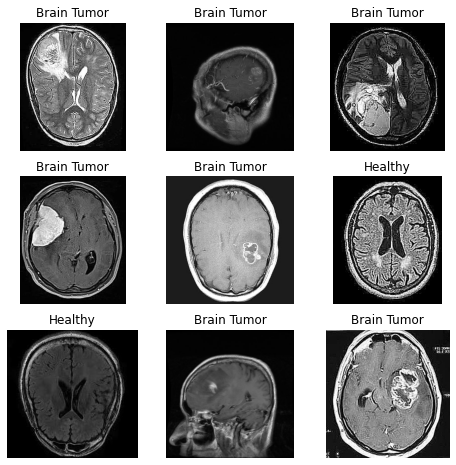

In [6]:
ds = BrainTumorDataset(imgs_path)
labels_map = {0: "Brain Tumor", 1: "Healthy"}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()

Create data loaders

In [7]:
batch_size = 32

In [8]:
train_loader, val_loader, test_loader = get_loaders(imgs_path, batch_size)

## Create InceptionV1

The original model does not use Batch Normalization is the ConvBlock. Instead ``LocalRespNorm`` is applied after the fist and the third conv. I observed that the original model has trouble learning and switch to `BN` overcomes that problem. A param `use_bn` is added to switch between the two versions of the model.

In [9]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, use_bn=False, **kwagrs) -> None:
        super().__init__()
        
        self.use_bn = use_bn

        self.conv = nn.Conv2d(in_channels, out_channels, **kwagrs)
        self.relu = nn.ReLU()

        if use_bn:
            self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        x = self.relu(x)
        return x

In [10]:
class InceptionBlock(nn.Module):

    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool, use_bn) -> None:
        super().__init__()

        self.branch_1 = ConvBlock(in_channels, out_1x1, kernel_size=1, stride=1, padding=0, use_bn=use_bn)
        self.branch_2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1, stride=1, padding=0, use_bn=use_bn),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1, use_bn=use_bn),
        )
        self.branch_3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1, stride=1, padding=0, use_bn=use_bn),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, stride=1, padding=2, use_bn=use_bn),
        )

        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels, out_pool, kernel_size=1, stride=1, padding=0, use_bn=use_bn)
        )


    def forward(self, x):
        out_1 = self.branch_1(x)
        out_2 = self.branch_2(x)
        out_3 = self.branch_3(x)
        out_4 = self.branch_4(x)
        out = torch.concat([out_1, out_2, out_3, out_4], dim=1)

        return out

In [11]:
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes, use_bn) -> None:
        super().__init__()

        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels, 128, kernel_size=1, stride=1, padding=0, use_bn=use_bn)
        self.relu_1 = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.relu_2 = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):

        x = self.avgpool(x)
        x = self.conv(x)
        x = self.relu_1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu_2(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [12]:
class InceptionV1(nn.Module):

    def __init__(self, num_classes: int, aux_logits: bool = True, use_bn: bool = True) -> None:
        super().__init__()

        self.aux_logits = aux_logits
        self.use_bn = use_bn

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layer 1
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3, use_bn=use_bn)
        self.lrn_1 = nn.LocalResponseNorm(11, alpha=0.00109999999404, beta=0.5, k=2)

        #layer 2
        self.conv21 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0, use_bn=use_bn) 
        self.conv22 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1, use_bn=use_bn)
        self.lrn_2 = nn.LocalResponseNorm(11, alpha=0.00109999999404, beta=0.5, k=2)

        # inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32, use_bn)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64, use_bn)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64, use_bn)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64, use_bn)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64, use_bn)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64, use_bn)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128, use_bn)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128, use_bn)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128, use_bn)

        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes, use_bn)
            self.aux2 = InceptionAux(528, num_classes, use_bn)
        else:
            self.aux1 = self.aux2 = None

        
    def forward(self, x):

        x = self.conv1(x) # output: 112×112×64
        x = self.maxpool(x) # output: 56x56×64
        if not self.use_bn:
            x = self.lrn_1(x)   

        x = self.conv21(x) # output: 56x56×64
        x = self.conv22(x) # output: 56x56×192
        if not self.use_bn:
            x = self.lrn_2(x)
        x = self.maxpool(x) # output: 28x28×192

        x = self.inception3a(x) # output: 28x28×256
        x = self.inception3b(x) # output: 28x28×480
        x = self.maxpool(x) # output: 14x14×480

        x = self.inception4a(x) # output: 14x14×512

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x) # output: 14x14×512
        x = self.inception4c(x) # output: 14x14×512
        x = self.inception4d(x) # output: 14x14×528
        
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x) # output: 14x14×528
        x = self.maxpool(x) # output: 7x7×832

        x = self.inception5a(x) # output: 7x7×832
        x = self.inception5b(x) # output: 7x7×1024

        x = self.avg_pool(x) # output: 1x1×1024
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)  # output: num_classes

        if self.aux_logits and self.training:
            return aux1, aux2, x
        
        return x

In [13]:
num_classes = len(class_to_idx)

In [14]:
model = InceptionV1(num_classes, use_bn=True)

In [15]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionV1                              [1, 2]                    4,334,340
├─ConvBlock: 1-1                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─ConvBlock: 1-3                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 64, 56, 56]           4,160
│    └─BatchNorm2d: 2-5                  [1, 64, 56, 56]           128
│    └─ReLU: 2-6                         [1, 64, 56, 56]           --
├─ConvBlock: 1-4                         [1, 192, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 192, 56, 56]          110,784
│    └─BatchNorm2d: 2-8                  [1, 192, 56, 56]        

## Train model on brain tumor dataset

In [16]:
num_epochs = 10
learning_rate = 0.005
weight_decay_rate = 0.0005
momentum = 0.9

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate, momentum=momentum)

In [18]:
total_steps = len(train_loader)

In [19]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        aux1_outputs, aux2_outputs, outputs = model(images)
        loss = criterion(outputs, labels) + 0.3 * criterion(aux1_outputs, labels) + 0.3 * criterion(aux2_outputs, labels)
        # outputs = model(images)
        # loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            _, _, outputs = model(images)
            # outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            correct += (preds == labels).sum()
            total += labels.size(0)

        acc = 100 * correct / total

    print(f"Validation accuracy: {acc:.2f}%")

Epoch [1/10], loss: 0.3406
Validation accuracy: 86.39%
Epoch [2/10], loss: 0.5315
Validation accuracy: 92.09%
Epoch [3/10], loss: 0.2014
Validation accuracy: 95.93%
Epoch [4/10], loss: 0.1471
Validation accuracy: 97.43%
Epoch [5/10], loss: 0.3174
Validation accuracy: 97.76%
Epoch [6/10], loss: 0.0606
Validation accuracy: 98.33%
Epoch [7/10], loss: 0.2109
Validation accuracy: 97.46%
Epoch [8/10], loss: 0.0470
Validation accuracy: 98.80%
Epoch [9/10], loss: 0.0158
Validation accuracy: 98.43%
Epoch [10/10], loss: 0.1583
Validation accuracy: 98.74%


In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} % ')

Test accuracy: 98.70 % 
